# Model

In [63]:
import numpy as np
import skfuzzy as fuzz
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist, jaccard, cityblock

class FuzzyClusteredCBR:
    def __init__(self, max_clusters=None,similarity_measure="euclidean",nclusters=None,k=5):
        self.max_clusters = max_clusters
        self.centroids = None
        self.memberships = None
        self.optimal_clusters = None
        self.case_base = None
        self.labels = None
        self.similarity_measure = similarity_measure
        self.accuraccy_by_ncluster = []
        self.nclusters = nclusters
        self.k = k
        
        
    def _calculate_distance(self, x, y):
        """Calculate distance using selected similarity measure"""
        if self.similarity_measure == 'euclidean':
            return cdist([x], [y], metric='euclidean')[0][0]
        elif self.similarity_measure == 'cityblock':
            return cityblock(x, y)
        else:  # jaccard
            return jaccard(x, y)
    
    def _predict_single_case(self, case, temp_case_base, temp_labels, centroids, temp_memberships):
        """
        Predict the label for a single case during leave-one-out validation
        
        Parameters:
        -----------
        case : array-like
            The case to predict
        temp_case_base : array-like
            Training cases excluding the current case
        temp_labels : array-like
            Labels excluding the current case
        centroids : array-like
            Cluster centroids
        temp_memberships : array-like
            Membership matrix excluding the current case
            
        Returns:
        --------
        predicted_label : int or string
            The predicted label for the case
        """
        # Calculate memberships for the case using provided centroids
        memberships = self._compute_memberships_with_centroids(case, centroids)
        
        # Find relevant clusters (membership > 0.1)
        relevant_clusters = np.where(memberships > 0.1)[0]
        
        # Get cases from relevant clusters with weights
        candidate_indices = []
        weights = []
        
        for cluster in relevant_clusters:
            cluster_cases = np.where(np.argmax(temp_memberships, axis=0) == cluster)[0]
            #aggregation 
            for case_idx in cluster_cases:
                weight = max([min(memberships[cluster], 
                               temp_memberships[cluster][case_idx])
                           for cluster in relevant_clusters])
                candidate_indices.append(case_idx)
                weights.append(weight)
        
        if not candidate_indices:
            # If no relevant clusters found, use nearest neighbor
            distances = np.array([self._calculate_distance(case, c) 
                                for c in temp_case_base])
            predicted_label = temp_labels[np.argmin(distances)]
        else:
            # Get top-k nearest neighbors based on similarity
            top_k_indices = np.argsort(weights)[-self.k:]
            top_k_labels = temp_labels[candidate_indices][top_k_indices]
            
            # Return the most frequent label among k-nearest neighbors
            predicted_label = max(set(top_k_labels), key=list(top_k_labels).count)
            return predicted_label
            
            
        return predicted_label

    def _compute_memberships_with_centroids(self, case, centroids):
        """Helper method to compute fuzzy memberships for a case using provided centroids"""
        distances = np.array([self._calculate_distance(case, centroid) 
                            for centroid in centroids])
        m = 2  # Fuzziness parameter
        n_clusters = len(centroids)
        
        memberships = np.zeros(n_clusters)
        for j in range(n_clusters):
            denominator = 0
            for k in range(n_clusters):
                if distances[k] == 0:
                    memberships[j] = 0
                    break
                denominator += (distances[j] / distances[k]) ** (2/(m-1))
            else:
                memberships[j] = 1 / denominator
        
        return memberships
            
    def fuzzy_cluster_casebase(self, case_base, labels):
        """
        Algorithm 1: Partition case-base into optimal number of fuzzy clusters
        """
        self.case_base = np.array(case_base)
        self.max_clusters = len(case_base)//2 if self.max_clusters is None else self.max_clusters
        self.labels = np.array(labels)
        best_accuracy = 0
        best_n_clusters = 2
        
        best_centroids = None
        best_memberships = None
        
            
        # Brute force search for optimal number of clusters
        iter_range = range(1, self.max_clusters+1) if self.nclusters is None else [self.nclusters]
        for n_clusters in iter_range:
            centroids, memberships, _, _, _, _, _ = fuzz.cluster.cmeans(
                case_base.T, n_clusters, m=2, error=0.005, maxiter=1000
            )
            
            # Leave-one-out validation
            correct_predictions = 0
            for i in range(len(case_base)):
                temp_case_base = np.delete(case_base, i, axis=0)
                temp_labels = np.delete(labels, i)
                temp_memberships = np.delete(memberships, i, axis=1)
                
                prediction = self._predict_single_case(
                    case_base[i], 
                    temp_case_base,
                    temp_labels,
                    centroids,
                    temp_memberships
                )
                
                if prediction == labels[i]:
                    correct_predictions += 1
            
            accuracy = correct_predictions / len(case_base)
            self.accuraccy_by_ncluster.append(accuracy)
            
            if accuracy >= best_accuracy:
                best_accuracy = accuracy
                best_n_clusters = n_clusters
                best_centroids = centroids
                best_memberships = memberships
        
        self.optimal_clusters = best_n_clusters
        self.centroids = best_centroids
        self.memberships = best_memberships
        return best_n_clusters,best_accuracy
    
    def predict_new_case(self, new_case):
        """
        Algorithm 2: Decision making process using fuzzy clustered CBR
        """
        if self.centroids is None:
            raise ValueError("Model must be trained using fuzzy_cluster_casebase before making predictions")
            
        # Fuzzy classification of new case
        memberships = self._compute_memberships_with_centroids(new_case, self.centroids)
        
        # Find relevant clusters
        relevant_clusters = np.where(memberships > 0.1)[0] # return indices of centroids above treshold
        
        # Get cases from relevant clusters with weights
        candidate_indices = []
        weights = []
        
        for cluster in relevant_clusters:
            cluster_cases = np.where(np.argmax(self.memberships, axis=0) == cluster)[0]
            for case_idx in cluster_cases:
                weight = max([min(memberships[cluster], 
                               self.memberships[cluster][case_idx])
                           for cluster in relevant_clusters])
                candidate_indices.append(case_idx)
                weights.append(weight)
        
        if not candidate_indices:
            distances = np.array([self._calculate_distance(new_case, case) 
                                for case in self.case_base])
            predicted_label = self.labels[np.argmin(distances)]
        else:
            # Get top-k nearest neighbors based on similarity
            top_k_indices = np.argsort(weights)[-self.k:]
            top_k_labels = self.labels[candidate_indices][top_k_indices]
            
            # Return the most frequent label among k-nearest neighbors
            predicted_label = max(set(top_k_labels), key=list(top_k_labels).count)


        
        # Store the new case with its membership vector
        self.case_base = np.vstack((self.case_base, new_case))
        self.labels = np.append(self.labels, predicted_label)
        
        # Update memberships matrix
        new_memberships = self._compute_memberships_with_centroids(new_case, self.centroids)
        self.memberships = np.column_stack((self.memberships, new_memberships))
        
        return predicted_label

# Data

## Wisconsin breast cancer

In [64]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd


In [65]:
# Load dataset
loaded_breast_cancer = load_breast_cancer()
X_breast_cancer, y_breast_cancer = loaded_breast_cancer.data, loaded_breast_cancer.target

In [66]:
breast_cancer_df = pd.DataFrame(data=loaded_breast_cancer.data,columns=loaded_breast_cancer.feature_names)
breast_cancer_df["target"] = loaded_breast_cancer.target
breast_cancer_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [67]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_breast_cancer = scaler.fit_transform(X_breast_cancer)

In [68]:
# Split data
X_train_breast_cancer, X_test_breast_cancer, y_train_breast_cancer, y_test_breast_cancer = train_test_split(X_breast_cancer, y_breast_cancer, test_size=0.2, random_state=42)

## Autonomic Forest Fire Application (AFFA)

In [69]:
# Load dataset
forestfires_df = pd.read_csv("forestfires.csv")

label_enc = LabelEncoder()
forestfires_df["month"] = label_enc.fit_transform(forestfires_df["month"])
forestfires_df["day"] = label_enc.fit_transform(forestfires_df["day"])

def classify_area(area):
    if area == 0:
        return 0  # No Fire
    elif area <= 1:
        return 1  # Small Fire
    elif area <= 10:
        return 2  # Medium Fire
    else:
        return 3  # Large Fire

#forestfires_df['target'] = forestfires_df['area'].apply(classify_area)

forestfires_df["target"] = np.where(forestfires_df["area"] > 0, 1, 0)  # 1 = Fire, 0 = No Fire
forestfires_df.drop("area",axis=1,inplace=True)
#forestfires_df = pd.read_csv("yes.csv")


X_forestfires, y_forestfires = forestfires_df.drop("target",axis=1).values, forestfires_df["target"].values
forestfires_df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,target
0,7,5,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
1,7,4,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
2,7,4,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
3,8,6,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
4,8,6,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,1,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,1
513,2,4,1,3,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,1
514,7,4,1,3,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,1
515,1,4,1,2,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0


In [70]:
forestfires_df["target"].value_counts()

target
1    270
0    247
Name: count, dtype: int64

In [71]:
scaler = StandardScaler()
X_forestfires = scaler.fit_transform(X_forestfires)

In [72]:
# Split data
X_train_forestfires, X_test_forestfires, y_train_forestfires, y_test_forestfires = train_test_split(X_forestfires, y_forestfires, test_size=0.2, random_state=42)

## Skin detection

In [73]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
skin_segmentation = fetch_ucirepo(id=229) 
  
# data (as pandas dataframes) 
X_skin_segmentation = skin_segmentation.data.features 
y_skin_segmentation = skin_segmentation.data.targets

In [74]:
skin_segmentation_df = X_skin_segmentation.copy()
skin_segmentation_df["target"] = y_skin_segmentation.values
skin_segmentation_df

,B,G,R,target
0,74,85,123,1
1,73,84,122,1
2,72,83,121,1
3,70,81,119,1
4,70,81,119,1
...,...,...,...,...
245052,163,162,112,2
245053,163,162,112,2
245054,163,162,112,2
245055,163,162,112,2


In [75]:
y_skin_segmentation.values
X_skin_segmentation.values

array([[ 74,  85, 123],
       [ 73,  84, 122],
       [ 72,  83, 121],
       ...,
       [163, 162, 112],
       [163, 162, 112],
       [255, 255, 255]], dtype=int64)

In [76]:
np.unique(y_skin_segmentation.values, return_counts=True)

(array([1, 2], dtype=int64), array([ 50859, 194198], dtype=int64))

In [77]:
_,X_skin_segmentation,_,y_skin_segmentation=train_test_split(X_skin_segmentation.values, y_skin_segmentation.values.ravel(), test_size=0.01, random_state=15)

In [78]:
y_skin_segmentation[y_skin_segmentation==2] = 0

In [79]:
np.unique(y_skin_segmentation, return_counts=True)

(array([0, 1], dtype=int64), array([1973,  478], dtype=int64))

In [80]:
# Split data
X_train_skin_segmentation, X_test_skin_segmentation, y_train_skin_segmentation, y_test_skin_segmentation = train_test_split(X_skin_segmentation, y_skin_segmentation, test_size=0.2, random_state=42)

# Case-studies

In [81]:
import time

## Wisconsin breast cancer

### euclidean

In [82]:
# Initialize and train
fcbr_breast_cancer_euclidean = FuzzyClusteredCBR(max_clusters=50,similarity_measure="euclidean")
best_n_clusters_breast_cancer_euclidean,best_accuracy_breast_cancer_euclidean = fcbr_breast_cancer_euclidean.fuzzy_cluster_casebase(X_train_breast_cancer, y_train_breast_cancer)
acc_var_breast_cancer_euclidean = fcbr_breast_cancer_euclidean.accuraccy_by_ncluster
print(f"best number of clusters : {best_n_clusters_breast_cancer_euclidean} , Best validation accuracy: {best_accuracy_breast_cancer_euclidean:.3f}")

best number of clusters : 50 , Best validation accuracy: 0.958


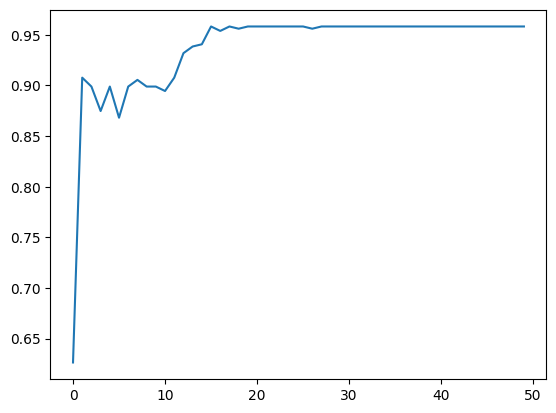

In [83]:
import matplotlib.pyplot as plt
plt.plot(acc_var_breast_cancer_euclidean)

In [84]:
start = time.time()
predicted_labels_breast_cancer_euclidean = []
for case in X_test_breast_cancer:
    predicted_label = fcbr_breast_cancer_euclidean.predict_new_case(case)
    predicted_labels_breast_cancer_euclidean.append(predicted_label)

accuracy_score(y_test_breast_cancer,predicted_labels_breast_cancer_euclidean)
stop = time.time()
breast_cancer_euclidean_time = stop - start

### cityblock

In [85]:
# Initialize and train
fcbr_breast_cancer_cityblock = FuzzyClusteredCBR(max_clusters=50,similarity_measure="cityblock")
best_n_clusters_breast_cancer_cityblock,best_accuracy_breast_cancer_cityblock = fcbr_breast_cancer_cityblock.fuzzy_cluster_casebase(X_train_breast_cancer, y_train_breast_cancer)
acc_var_breast_cancer_cityblock = fcbr_breast_cancer_cityblock.accuraccy_by_ncluster
print(f"best number of clusters : {best_n_clusters_breast_cancer_cityblock} , Best validation accuracy: {best_accuracy_breast_cancer_cityblock:.3f}")

best number of clusters : 21 , Best validation accuracy: 0.971


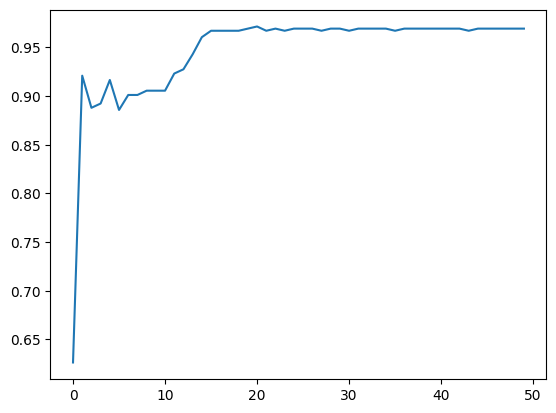

In [86]:
plt.plot(acc_var_breast_cancer_cityblock)

In [87]:
start = time.time()
predicted_labels_breast_cancer_cityblock = []
for case in X_test_breast_cancer:
    predicted_label = fcbr_breast_cancer_cityblock.predict_new_case(case)
    predicted_labels_breast_cancer_cityblock.append(predicted_label)

accuracy_score(y_test_breast_cancer,predicted_labels_breast_cancer_cityblock)
stop = time.time()
breast_cancer_cityblock_time = stop - start

### jaccard

In [88]:
# Initialize and train
fcbr_breast_cancer_jaccard = FuzzyClusteredCBR(max_clusters=50,similarity_measure="jaccard")
best_n_clusters_breast_cancer_jaccard,best_accuracy_breast_cancer_jaccard = fcbr_breast_cancer_jaccard.fuzzy_cluster_casebase(X_train_breast_cancer, y_train_breast_cancer)
acc_var_breast_cancer_jaccard = fcbr_breast_cancer_jaccard.accuraccy_by_ncluster
print(f"best number of clusters : {best_n_clusters_breast_cancer_jaccard} , Best validation accuracy: {best_accuracy_breast_cancer_jaccard:.3f}")

best number of clusters : 50 , Best validation accuracy: 0.644


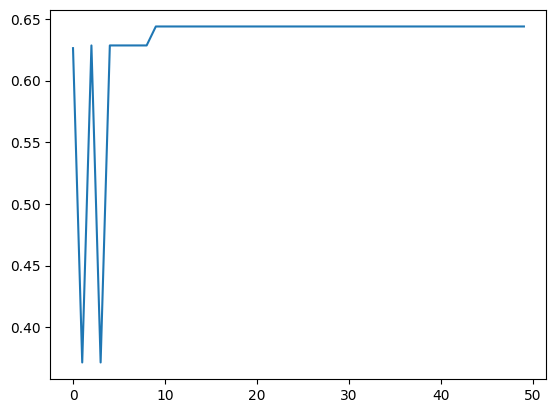

In [89]:
plt.plot(acc_var_breast_cancer_jaccard)

In [90]:
start = time.time()
predicted_labels_breast_cancer_jaccard = []
for case in X_test_breast_cancer:
    predicted_label = fcbr_breast_cancer_jaccard.predict_new_case(case)
    predicted_labels_breast_cancer_jaccard.append(predicted_label)

accuracy_score(y_test_breast_cancer,predicted_labels_breast_cancer_jaccard)
stop = time.time()
breast_cancer_jaccard_time = stop - start

### Results

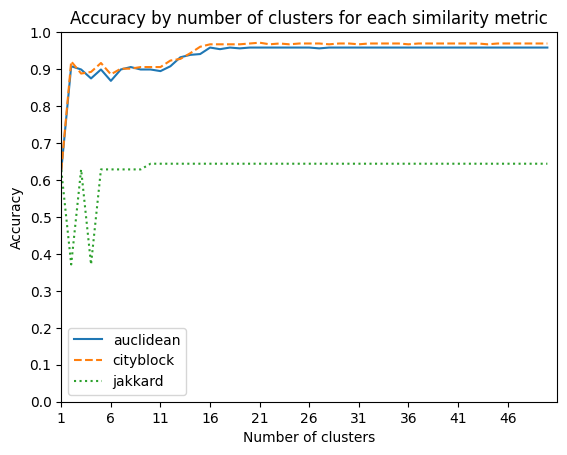

In [91]:
# Create the plot
plt.plot(acc_var_breast_cancer_euclidean, label='auclidean', linestyle='-')
plt.plot(acc_var_breast_cancer_cityblock, label='cityblock', linestyle='--')
plt.plot(acc_var_breast_cancer_jaccard, label='jakkard', linestyle=':')


# Add labels, title, and legend
plt.xlabel("Number of clusters")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Start y-axis from 0
plt.xlim(1, 50)  # Start y-axis from 0
plt.xticks(np.arange(len(acc_var_breast_cancer_euclidean)), np.arange(1, len(acc_var_breast_cancer_euclidean) + 1))  # Change tick labels from 0-based to 1-based
plt.locator_params(axis="y", nbins=10)
plt.locator_params(axis="x", nbins=10)
plt.title("Accuracy by number of clusters for each similarity metric")
plt.legend()

# Show the plot
plt.show()

In [92]:
results = pd.DataFrame(columns=["Dataset",'Best number of clusters','Best accuracy' , 'Best similarity measure', 'Testing time'])

breast_cancer_rs = {
    'euclidean' : [best_accuracy_breast_cancer_euclidean,best_n_clusters_breast_cancer_euclidean,breast_cancer_euclidean_time],
    'cityblock' : [best_accuracy_breast_cancer_cityblock,best_n_clusters_breast_cancer_cityblock,breast_cancer_cityblock_time],
    'jaccard' : [best_accuracy_breast_cancer_jaccard,best_n_clusters_breast_cancer_jaccard,breast_cancer_jaccard_time]
}

breast_cancer_best = max(breast_cancer_rs, key=lambda k: breast_cancer_rs[k][0])

results.loc[len(results)] = ["Breast Cancer", breast_cancer_rs[breast_cancer_best][1],breast_cancer_rs[breast_cancer_best][0],breast_cancer_best,breast_cancer_rs[breast_cancer_best][2]]

results

,Dataset,Best number of clusters,Best accuracy,Best similarity measure,Testing time
0,Breast Cancer,21,0.971429,cityblock,0.182073


## Autonomic Forest Fire Application (AFFA)

### euclidean

In [93]:
# Initialize and train
fcbr_forestfires_euclidean = FuzzyClusteredCBR(max_clusters=10,similarity_measure="euclidean")
best_n_clusters_forestfires_euclidean,best_accuracy_forestfires_euclidean = fcbr_forestfires_euclidean.fuzzy_cluster_casebase(X_train_forestfires, y_train_forestfires)
acc_var_forestfires_euclidean = fcbr_forestfires_euclidean.accuraccy_by_ncluster
print(f"best number of clusters : {best_n_clusters_forestfires_euclidean} , Best validation accuracy: {best_accuracy_forestfires_euclidean:.3f}")

best number of clusters : 3 , Best validation accuracy: 0.540


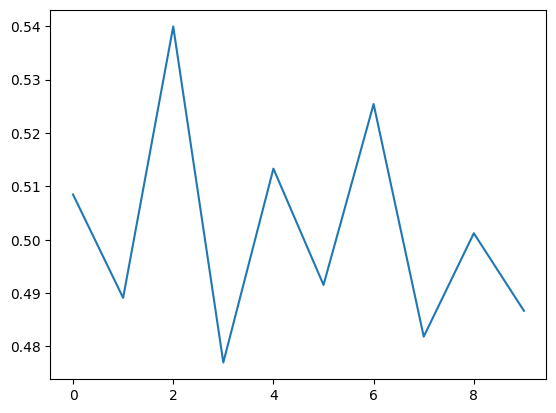

In [94]:
plt.plot(acc_var_forestfires_euclidean)

In [95]:
start = time.time()
predicted_labels_forestfires_euclidean = []
for case in X_test_forestfires:
    predicted_label = fcbr_forestfires_euclidean.predict_new_case(case)
    predicted_labels_forestfires_euclidean.append(predicted_label)

np.sum(y_test_forestfires == predicted_labels_forestfires_euclidean) / len(y_test_forestfires)
stop = time.time()
forestfires_euclidean_time = stop - start


### cityblock

In [96]:
# Initialize and train
fcbr_forestfires_cityblock = FuzzyClusteredCBR(max_clusters=10,similarity_measure="cityblock")
best_n_clusters_forestfires_cityblock,best_accuracy_forestfires_cityblock = fcbr_forestfires_cityblock.fuzzy_cluster_casebase(X_train_forestfires, y_train_forestfires)
acc_var_forestfires_cityblock = fcbr_forestfires_cityblock.accuraccy_by_ncluster
print(f"best number of clusters : {best_n_clusters_forestfires_cityblock} , Best validation accuracy: {best_accuracy_forestfires_cityblock:.3f}")

best number of clusters : 1 , Best validation accuracy: 0.508


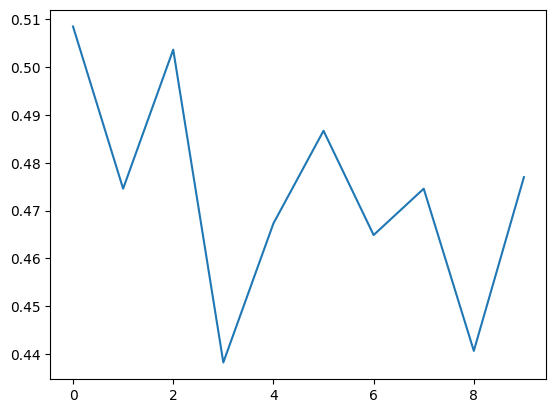

In [97]:
plt.plot(acc_var_forestfires_cityblock)

In [98]:
start = time.time()
predicted_labels_forestfires_cityblock = []
for case in X_test_forestfires:
    predicted_label = fcbr_forestfires_cityblock.predict_new_case(case)
    predicted_labels_forestfires_cityblock.append(predicted_label)
predicted_labels_forestfires_cityblock = np.array(predicted_labels_forestfires_cityblock)

#accuracy_score(y_test_forestfires,predicted_labels_forestfires_cityblock)
np.sum(y_test_forestfires == predicted_labels_forestfires_cityblock) / len(y_test_forestfires)
stop = time.time()
forestfires_cityblock_time = stop - start


### jaccard

In [99]:
# Initialize and train
fcbr_forestfires_jaccard = FuzzyClusteredCBR(max_clusters=10,similarity_measure="jaccard")
best_n_clusters_forestfires_jaccard,best_accuracy_forestfires_jaccard = fcbr_forestfires_jaccard.fuzzy_cluster_casebase(X_train_forestfires, y_train_forestfires)
acc_var_forestfires_jaccard = fcbr_forestfires_jaccard.accuraccy_by_ncluster
print(f"best number of clusters : {best_n_clusters_forestfires_jaccard} , Best validation accuracy: {best_accuracy_forestfires_jaccard:.3f}")

best number of clusters : 4 , Best validation accuracy: 0.535


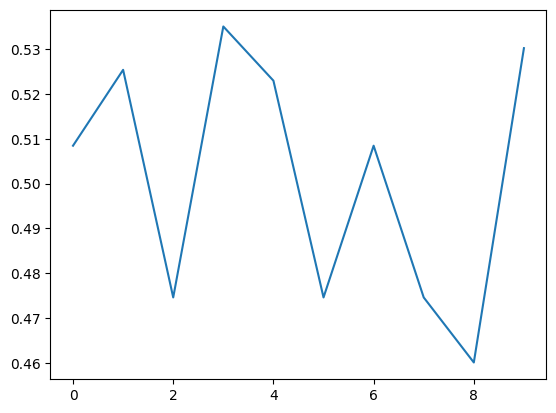

In [100]:
plt.plot(acc_var_forestfires_jaccard)

In [101]:
start = time.time()
predicted_labels_forestfires_jaccard = []
for case in X_test_forestfires:
    predicted_label = fcbr_forestfires_jaccard.predict_new_case(case)
    predicted_labels_forestfires_jaccard.append(predicted_label)

np.sum(y_test_forestfires == predicted_labels_forestfires_jaccard) / len(y_test_forestfires)
stop = time.time()
forestfire_jaccard_time = stop - start


### Results

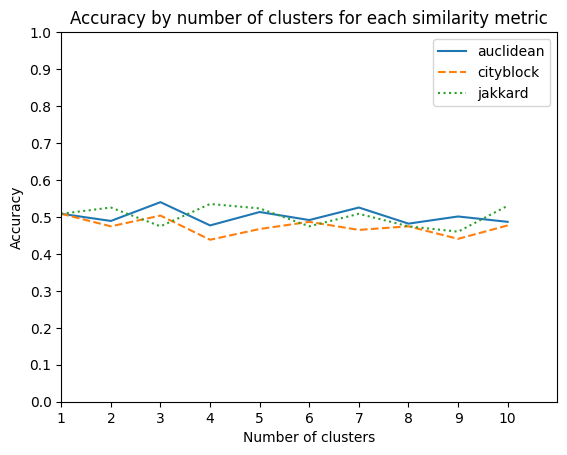

In [102]:
# Create the plot
plt.plot(acc_var_forestfires_euclidean, label='auclidean', linestyle='-')
plt.plot(acc_var_forestfires_cityblock, label='cityblock', linestyle='--')
plt.plot(acc_var_forestfires_jaccard, label='jakkard', linestyle=':')


# Add labels, title, and legend
plt.xlabel("Number of clusters")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Start y-axis from 0
plt.xlim(1, 10)  # Start y-axis from 0
plt.xticks(np.arange(len(acc_var_forestfires_euclidean)), np.arange(1, len(acc_var_forestfires_euclidean) + 1))  # Change tick labels from 0-based to 1-based
plt.locator_params(axis="y", nbins=10)
plt.locator_params(axis="x", nbins=10)
plt.title("Accuracy by number of clusters for each similarity metric")
plt.legend()

# Show the plot
plt.show()

In [103]:
forestfires_rs = {
    'euclidean' : [best_accuracy_forestfires_euclidean,best_n_clusters_forestfires_euclidean,forestfires_euclidean_time],
    'cityblock' : [best_accuracy_forestfires_cityblock,best_n_clusters_forestfires_cityblock,forestfires_cityblock_time],
    'jaccard' : [best_accuracy_forestfires_jaccard,best_n_clusters_forestfires_jaccard,forestfire_jaccard_time]
}

forestfires_best = max(forestfires_rs, key=lambda k: forestfires_rs[k][0])

results.loc[len(results)] = ["Forest Fire", forestfires_rs[forestfires_best][1],forestfires_rs[forestfires_best][0],forestfires_best,forestfires_rs[forestfires_best][2]]

results

,Dataset,Best number of clusters,Best accuracy,Best similarity measure,Testing time
0,Breast Cancer,21,0.971429,cityblock,0.182073
1,Forest Fire,3,0.539952,euclidean,0.125005


## Skin detection

### euclidean

In [104]:
# Initialize and train
fcbr_skin_segmentation_euclidean = FuzzyClusteredCBR(max_clusters=35,similarity_measure="euclidean")
best_n_clusters_skin_segmentation_euclidean,best_accuracy_skin_segmentation_euclidean = fcbr_skin_segmentation_euclidean.fuzzy_cluster_casebase(X_train_skin_segmentation, y_train_skin_segmentation)
acc_var_skin_segmentation_euclidean = fcbr_skin_segmentation_euclidean.accuraccy_by_ncluster
print(f"best number of clusters : {best_n_clusters_skin_segmentation_euclidean} , Best validation accuracy: {best_accuracy_skin_segmentation_euclidean:.3f}")

best number of clusters : 35 , Best validation accuracy: 0.971


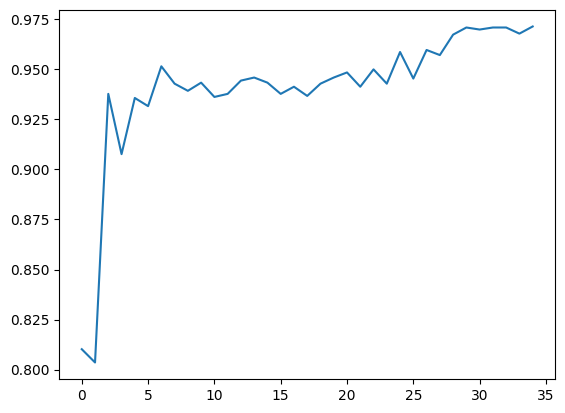

In [105]:
plt.plot(acc_var_skin_segmentation_euclidean)

In [106]:
start = time.time()
predicted_labels_skin_segmentation_euclidean = []
for case in X_test_skin_segmentation:
    predicted_label = fcbr_skin_segmentation_euclidean.predict_new_case(case)
    predicted_labels_skin_segmentation_euclidean.append(predicted_label)
predicted_labels_skin_segmentation_euclidean = np.array(predicted_labels_skin_segmentation_euclidean)

#accuracy_score(y_test_skin_segmentation,predicted_labels_skin_segmentation_euclidean)
np.sum(y_test_skin_segmentation == predicted_labels_skin_segmentation_euclidean) / len(y_test_skin_segmentation)
stop = time.time()
skin_segmentation_euclidean_time = stop - start


### cityblock

In [107]:
# Initialize and train
fcbr_skin_segmentation_cityblock = FuzzyClusteredCBR(max_clusters=35,similarity_measure="cityblock")
best_n_clusters_skin_segmentation_cityblock,best_accuracy_skin_segmentation_cityblock = fcbr_skin_segmentation_cityblock.fuzzy_cluster_casebase(X_train_skin_segmentation, y_train_skin_segmentation)
acc_var_skin_segmentation_cityblock = fcbr_skin_segmentation_cityblock.accuraccy_by_ncluster
print(f"best number of clusters : {best_n_clusters_skin_segmentation_cityblock} , Best validation accuracy: {best_accuracy_skin_segmentation_cityblock:.3f}")

best number of clusters : 35 , Best validation accuracy: 0.972


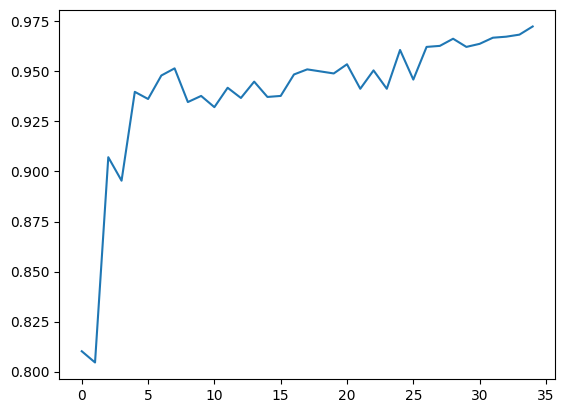

In [108]:
plt.plot(acc_var_skin_segmentation_cityblock)

In [109]:
start = time.time()
predicted_labels_skin_segmentation_cityblock = []
for case in X_test_skin_segmentation:
    predicted_label = fcbr_skin_segmentation_cityblock.predict_new_case(case)
    predicted_labels_skin_segmentation_cityblock.append(predicted_label)
predicted_labels_skin_segmentation_cityblock = np.array(predicted_labels_skin_segmentation_cityblock)

#accuracy_score(y_test_skin_segmentation,predicted_labels_skin_segmentation_cityblock)
np.sum(y_test_skin_segmentation == predicted_labels_skin_segmentation_cityblock) / len(y_test_skin_segmentation)
stop = time.time()
skin_segmentation_cityblock_time = stop - start


In [110]:
y_test_skin_segmentation.shape


(491,)

### jaccard

In [ ]:
# Initialize and train
fcbr_skin_segmentation_jaccard = FuzzyClusteredCBR(max_clusters=35,similarity_measure="jaccard")
best_n_clusters_skin_segmentation_jaccard,best_accuracy_skin_segmentation_jaccard = fcbr_skin_segmentation_jaccard.fuzzy_cluster_casebase(X_train_skin_segmentation, y_train_skin_segmentation)
acc_var_skin_segmentation_jaccard = fcbr_skin_segmentation_jaccard.accuraccy_by_ncluster
print(f"best number of clusters : {best_n_clusters_skin_segmentation_jaccard} ,Best validation accuracy: {best_accuracy_skin_segmentation_jaccard:.3f}")

best number of clusters : 35 ,-+ Best validation accuracy: 0.848


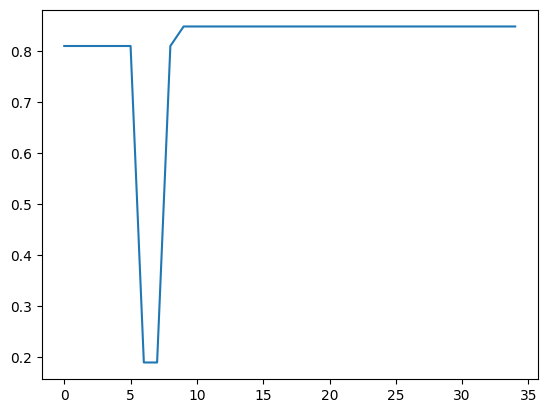

In [112]:
plt.plot(acc_var_skin_segmentation_jaccard)

In [113]:
start = time.time()
predicted_labels_skin_segmentation_jaccard = []
for case in X_test_skin_segmentation:
    predicted_label = fcbr_skin_segmentation_jaccard.predict_new_case(case)
    predicted_labels_skin_segmentation_jaccard.append(predicted_label)

#accuracy_score(y_test_skin_segmentation,predicted_labels_skin_segmentation_jaccard)
np.sum(y_test_skin_segmentation == predicted_labels_skin_segmentation_jaccard) / len(y_test_skin_segmentation)
stop = time.time()
skin_segmentation_jaccard_time = stop - start


### Results

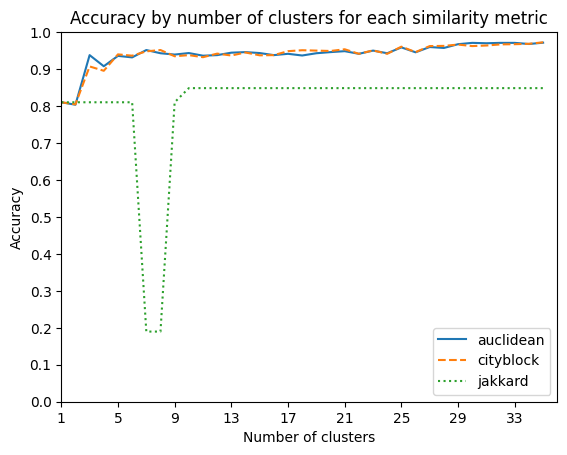

In [114]:
# Create the plot
plt.plot(acc_var_skin_segmentation_euclidean, label='auclidean', linestyle='-')
plt.plot(acc_var_skin_segmentation_cityblock, label='cityblock', linestyle='--')
plt.plot(acc_var_skin_segmentation_jaccard, label='jakkard', linestyle=':')


# Add labels, title, and legend
plt.xlabel("Number of clusters")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Start y-axis from 0
plt.xlim(1, 35)  # Start y-axis from 0
plt.xticks(np.arange(len(acc_var_skin_segmentation_euclidean)), np.arange(1, len(acc_var_skin_segmentation_euclidean) + 1))  # Change tick labels from 0-based to 1-based
plt.locator_params(axis="y", nbins=10)
plt.locator_params(axis="x", nbins=10)
plt.title("Accuracy by number of clusters for each similarity metric")
plt.legend()

# Show the plot
plt.show()

In [115]:
skin_segmentation_rs = {
    'euclidean' : [best_accuracy_skin_segmentation_euclidean,best_n_clusters_skin_segmentation_euclidean,skin_segmentation_euclidean_time],
    'cityblock' : [best_accuracy_skin_segmentation_cityblock,best_n_clusters_skin_segmentation_cityblock,skin_segmentation_cityblock_time],
    'jaccard' : [best_accuracy_skin_segmentation_jaccard,best_n_clusters_skin_segmentation_jaccard,fcbr_skin_segmentation_jaccard]
}

skin_segmentation_best = max(skin_segmentation_rs, key=lambda k: skin_segmentation_rs[k][0])

results.loc[len(results)] = ["Skin Segmentation", skin_segmentation_rs[skin_segmentation_best][1],skin_segmentation_rs[skin_segmentation_best][0],skin_segmentation_best,skin_segmentation_rs[skin_segmentation_best][2]]

results

,Dataset,Best number of clusters,Best accuracy,Best similarity measure,Testing time
0,Breast Cancer,21,0.971429,cityblock,0.182073
1,Forest Fire,3,0.539952,euclidean,0.125005
2,Skin Segmentation,35,0.972449,cityblock,1.544511


## Comparing time

In [116]:
results

,Dataset,Best number of clusters,Best accuracy,Best similarity measure,Testing time
0,Breast Cancer,21,0.971429,cityblock,0.182073
1,Forest Fire,3,0.539952,euclidean,0.125005
2,Skin Segmentation,35,0.972449,cityblock,1.544511


### breast cancer

In [117]:
# Initialize and train
fcbr_breast_cancer_cityblock_nocluster = FuzzyClusteredCBR(similarity_measure="cityblock",nclusters=1)
best_n_clusters_breast_cancer_cityblock_nocluster,best_accuracy_breast_cancer_cityblock_nocluster = fcbr_breast_cancer_cityblock_nocluster.fuzzy_cluster_casebase(X_train_breast_cancer, y_train_breast_cancer)
print(f"Best validation accuracy: {best_accuracy_breast_cancer_cityblock_nocluster:.3f}")

Best validation accuracy: 0.626


In [133]:
start = time.time()
predicted_labels_breast_cancer_cityblock_nocluster = []
for case in X_test_breast_cancer:
    predicted_label = fcbr_breast_cancer_cityblock_nocluster.predict_new_case(case)
    predicted_labels_breast_cancer_cityblock_nocluster.append(predicted_label)

accuracy_score(y_test_breast_cancer,predicted_labels_breast_cancer_cityblock_nocluster)
stop = time.time()
breast_cancer_cityblock_time_nocluster = stop - start

### Forest Fire

In [119]:
# Initialize and train
fcbr_forestfires_cityblock_nocluster = FuzzyClusteredCBR(max_clusters=10,similarity_measure="euclidean",nclusters=1)
best_n_clusters_forestfires_cityblock_nocluster,best_accuracy_forestfires_cityblock_nocluster = fcbr_forestfires_cityblock_nocluster.fuzzy_cluster_casebase(X_train_forestfires, y_train_forestfires)
print(f"Best validation accuracy: {best_accuracy_forestfires_cityblock_nocluster:.3f}")

Best validation accuracy: 0.508


In [130]:
start = time.time()
predicted_labels_forestfires_cityblock_nocluster = []
for case in X_test_forestfires:
    predicted_label = fcbr_forestfires_cityblock_nocluster.predict_new_case(case)
    predicted_labels_forestfires_cityblock_nocluster.append(predicted_label)
predicted_labels_forestfires_cityblock_nocluster = np.array(predicted_labels_forestfires_cityblock_nocluster)

#accuracy_score(y_test_forestfires,predicted_labels_forestfires_cityblock_nocluster)
np.sum(y_test_forestfires == predicted_labels_forestfires_cityblock_nocluster) / len(y_test_forestfires)
stop = time.time()
forestfires_cityblock_time_nocluster = stop - start


### Skin Detection

In [125]:
# Initialize and train
fcbr_skin_segmentation_cityblock_nocluster = FuzzyClusteredCBR(max_clusters=10,similarity_measure="cityblock",nclusters=1)
best_n_clusters_skin_segmentation_cityblock_nocluster,best_accuracy_skin_segmentation_cityblock_nocluster = fcbr_skin_segmentation_cityblock_nocluster.fuzzy_cluster_casebase(X_train_skin_segmentation, y_train_skin_segmentation)
print(f"Best validation accuracy: {best_accuracy_skin_segmentation_cityblock_nocluster:.3f}")

Best validation accuracy: 0.810


In [126]:
start = time.time()
predicted_labels_skin_segmentation_cityblock_nocluster = []
for case in X_test_skin_segmentation:
    predicted_label = fcbr_skin_segmentation_cityblock_nocluster.predict_new_case(case)
    predicted_labels_skin_segmentation_cityblock_nocluster.append(predicted_label)
predicted_labels_skin_segmentation_cityblock_nocluster = np.array(predicted_labels_skin_segmentation_cityblock_nocluster)

#accuracy_score(y_test_skin_segmentation,predicted_labels_skin_segmentation_cityblock_nocluster)
np.sum(y_test_skin_segmentation == predicted_labels_skin_segmentation_cityblock_nocluster) / len(y_test_skin_segmentation)
stop = time.time()
skin_segmentation_cityblock_time_nocluster = stop - start


In [134]:
results["Testing time no cluster"] = [breast_cancer_cityblock_time_nocluster,forestfires_cityblock_time_nocluster,skin_segmentation_cityblock_time_nocluster]

In [135]:
results

,Dataset,Best number of clusters,Best accuracy,Best similarity measure,Testing time,Testing time no cluster
0,Breast Cancer,21,0.971429,cityblock,0.182073,0.207027
1,Forest Fire,3,0.539952,euclidean,0.125005,0.203013
2,Skin Segmentation,35,0.972449,cityblock,1.544511,3.083595
